In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Github/
%cd hge_extended
%ls -a

In [ ]:
!pip install aeon
!pip install openml
!pip install prince
!pip install scikit-learn-extra

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
import copy
from utils import prep_data, plot_dendrogram, get_score, get_significance
from set_dissimilarity import get_diss
from build_hier import build_tree
from clf_repo import clf_dict
import warnings
warnings.filterwarnings("ignore")

In [ ]:
clf_name  = 'xgb'
dset_name = 'Glass'
diss_type = 'ccm'
out_type  = 'obs_vec'
link_type = 'hdc'
split_fun = 'kmeans'

k_run=10
te_size=0.2
plot_tree=True

hc_type='lcpn+f'
chain_type='prod'
eval_metric='f1'
multi_=False

In [ ]:
# load dataset
(X,y),labels = prep_data(dset_name=dset_name,
                         repo='uci',
                         return_class_labels=True,
                         orig_split=True,
                         return_xy=True)

In [ ]:
# Obtain dissimilarity
diss_ = get_diss(X,
                 y,
                 diss_type = diss_type,
                 out_type  = out_type)

In [ ]:
tree_kwargs={'link_type':link_type,
             'input_type':out_type,
             'split_fun':split_fun}

# dendrogram display settings
n_row = k_run//5+1
if n_row>1:
    n_col = 5
else:
    n_col = k_run

run 0 f1 scores fc:0.6415, hc:0.6313, learning efficiency:0.9841
run 1 f1 scores fc:0.8080, hc:0.8080, learning efficiency:1.0000
run 2 f1 scores fc:0.7300, hc:0.7300, learning efficiency:1.0000
run 3 f1 scores fc:0.5505, hc:0.6161, learning efficiency:1.1191
run 4 f1 scores fc:0.6407, hc:0.6713, learning efficiency:1.0476
run 5 f1 scores fc:0.6769, hc:0.6649, learning efficiency:0.9823
run 6 f1 scores fc:0.4596, hc:0.4820, learning efficiency:1.0488
run 7 f1 scores fc:0.7288, hc:0.6941, learning efficiency:0.9523
run 8 f1 scores fc:0.6783, hc:0.6200, learning efficiency:0.9140
run 9 f1 scores fc:0.7722, hc:0.7833, learning efficiency:1.0143
fc mean:0.6687±0.0984, hc mean:0.6701±0.0885, learning efficiency:1.0021 (p=0.8886)


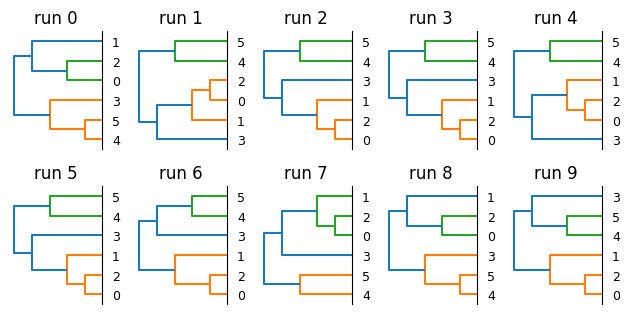

In [ ]:
# Monte Carlo cross validation
scores_hc=[]
scores_fc=[]
for r_ in range(k_run):
    t_run=time()

    # splitting for Monte Carlo
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=te_size, random_state=r_, stratify=y)

    # building hieararchy in binary tree form
    tree_kwargs['y_test']=y_test
    tree, Z = build_tree(diss_, y_train, **tree_kwargs)

    if plot_tree:
        if r_==0:
            plt.close('all')
            plt.figure()
        plt.subplot(n_row,n_col,r_+1)
        plot_dendrogram(Z, orient="left", class_list=labels)
        ax=plt.gca()
        ax.spines[['left', 'top', 'bottom']].set_visible(False)
        plt.xticks([])
        plt.title(f'run {r_:d}')
        if r_==k_run-1:plt.tight_layout()

    # HC
    clf_base = copy.deepcopy(clf_dict[clf_name])
    tree.fit(clf_base, x_train, hc_type=hc_type, multi_process=multi_)
    tree.predict(x_test, hc_type=hc_type, chain_type=chain_type)
    score_hc = tree.score(eval_metric=eval_metric)
    scores_hc.append(score_hc)

    # FC
    clf_base.fit(x_train,y_train)
    y_pred = clf_base.predict(x_test)
    pred_proba_fc = clf_base.predict_proba(x_test)
    score_fc = get_score(y_test, y_pred=y_pred, pred_proba=pred_proba_fc, eval_metric=eval_metric)
    scores_fc.append(score_fc)

    # Display results
    print(f'run {r_} {eval_metric} scores fc:{score_fc:.4f}, hc:{score_hc:.4f}, learning efficiency:{score_hc/score_fc:.4f}')

le_mean, p_val, _ = get_significance(scores_hc,scores_fc)
score_fc_mean = np.mean(scores_fc)
score_hc_mean = np.mean(scores_hc)
print(f'fc mean:{score_fc_mean:.4f}\u00B1{np.std(scores_fc):.4f}, hc mean:{score_hc_mean:.4f}\u00B1{np.std(scores_hc):.4f}, learning efficiency:{le_mean:.4f} (p={p_val:.4f})')